In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

#### Limit the GPU usage,if not the Program will consume the whole GPU

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])
  except RuntimeError as e:
    print(e)

In [3]:
train_data=pd.read_csv("mnist_train.csv")
test_data=pd.read_csv("mnist_test.csv")

In [4]:
train_data.shape

(60000, 785)

In [5]:
test_data.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [40]:
Y=train_data["label"].values
X=train_data.drop(labels=["label"],axis=1).values
Y_test=test_data["label"].values
X_test=test_data.drop(labels=["label"],axis=1).values
Y_test.shape

(10000,)

#### Reshaping the data


In [7]:
X=X.reshape(-1,28,28,1)
X_test=X_test.reshape(-1,28,28,1)

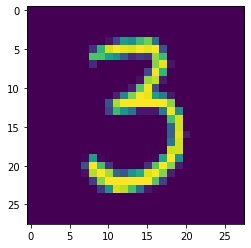

In [8]:
plt.imshow(X[50,:,:,0])

In [9]:
X=X/255.0
X_test=X_test/255.0

#### To perform One Hot Encoding in Keras we will use to_Categorical to convert the labels  into one hot vectors

In [10]:
from tensorflow.keras.utils import to_categorical
Y=to_categorical(Y,num_classes=10)
Y.shape

(60000, 10)

#### We already have a test dataset but we split the training set further to a validation set for cross_validation

In [11]:
from sklearn.model_selection import train_test_split
X_train,X_val,Y_train,Y_val=train_test_split(X,Y,test_size=0.1,random_state=7)

### Creating a Sequential Model Using keras Sequential.We will use CNN to build this classifier

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,Flatten,MaxPool2D,BatchNormalization

In [13]:
model=Sequential()

model.add(Conv2D(filters=64,kernel_size=(5,5),padding="Same",activation="relu",input_shape=(28,28,1)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64,kernel_size=(5,5),padding="Same",activation="relu",input_shape=(28,28,1)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=64,kernel_size=(5,5),padding="Same",activation="relu",input_shape=(28,28,1)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=64,kernel_size=(5,5),padding="Same",activation="relu",input_shape=(28,28,1)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256,activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(10,activation="softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        1664      
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        102464    
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0

In [24]:
model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])


#### We will attach a callback which will monitor the loss of the Model when the data is fit into it.

In [15]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [16]:
callback=ReduceLROnPlateau(monitor="val_accuracy",patience=3,verbose=0,factor=0.7,min_lr=0.00001)


#### We will use Data Augmentation for generating addition data

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [26]:
datagen=ImageDataGenerator(horizontal_flip=False)
datagen.fit(X_train)

In [28]:
history=model.fit(datagen.flow(X_train,Y_train,batch_size=128),epochs=3,
                               validation_data=(X_val,Y_val),verbose=1,
                              steps_per_epoch=X_train.shape[0]//128,callbacks=[callback])

Epoch 1/3
421/421 [==============================] - 191s 455ms/step - loss: 0.0817 - accuracy: 0.9742 - val_loss: 0.1019 - val_accuracy: 0.9688 - lr: 0.0010
Epoch 2/3
421/421 [==============================] - 218s 518ms/step - loss: 0.0533 - accuracy: 0.9836 - val_loss: 0.0430 - val_accuracy: 0.9868 - lr: 0.0010
Epoch 3/3
421/421 [==============================] - 226s 536ms/step - loss: 0.0424 - accuracy: 0.9866 - val_loss: 0.0289 - val_accuracy: 0.9923 - lr: 0.0010


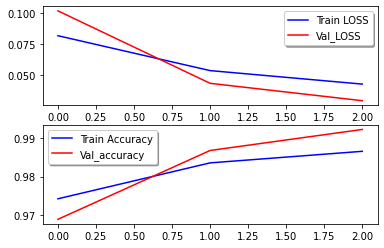

In [30]:
fig,ax=plt.subplots(2,1)
ax[0].plot(history.history["loss"],color="b",label="Train LOSS")
ax[0].plot(history.history["val_loss"],color="r",label="Val_LOSS",axes=ax[0])
legend=ax[0].legend(loc="best",shadow=True)
ax[1].plot(history.history["accuracy"],color="b",label="Train Accuracy")
ax[1].plot(history.history["val_accuracy"],color="r",label="Val_accuracy")
legend=ax[1].legend(loc="best",shadow=True)

In [36]:
result=model.predict(X_test)
result=np.argmax(result,axis=1)
result=pd.Series(result,name="Label")
result.shape

(10000,)

In [45]:
from sklearn.metrics import accuracy_score,f1_score

In [48]:
print(accuracy_score(result,Y_test))
#print(f1_score(result,Y_test,average=None))

0.9908


### Our model Came up with an Accuracy score of 0.9908 in the test set

In [44]:
result.to_csv("test_prediction.csv",index=False)